# Users vs Bots Classification

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

# Load Dataset

In [2]:
df = pd.read_csv("bots_vs_users.csv")

# Overview

In [3]:
# Basic info
print("\n Dataset Shape:", df.shape)
print("\n First 5 rows:")
print(df.head())

# Column overview
print("\n Column Names:\n", df.columns.tolist())

# Data types
print("\n Data Types:")
print(df.dtypes.value_counts())
print(df.dtypes)

# Missing values
print("\n Missing Values (Top 10):")
print(df.isnull().sum().sort_values(ascending=False).head(10))

# Categorical & numerical feature breakdown
categorical_cols = df.select_dtypes(include='object').columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

print("\n Categorical Columns ({}):\n".format(len(categorical_cols)), list(categorical_cols))
print("\n Numerical Columns ({}):\n".format(len(numerical_cols)), list(numerical_cols))

# Target column preview
if 'target' in df.columns or 'label' in df.columns or 'is_bot' in df.columns:
    target_col = next((col for col in ['target', 'label', 'is_bot'] if col in df.columns), None)
    print(f"\n Target Column ('{target_col}') Distribution:")
    print(df[target_col].value_counts())
else:
    print("\n Target column not clearly labeled.")


 Dataset Shape: (5874, 60)

 First 5 rows:
  has_domain has_birth_date has_photo can_post_on_wall can_send_message  \
0        1.0            1.0       0.0              0.0              0.0   
1        1.0            1.0       0.0              0.0              0.0   
2        1.0            1.0       0.0              0.0              0.0   
3        1.0            1.0       0.0              0.0              0.0   
4        1.0            1.0       0.0              0.0              0.0   

  has_website gender has_short_name has_first_name has_last_name  ...  \
0         0.0    1.0            1.0            1.0           1.0  ...   
1         0.0    1.0            1.0            1.0           1.0  ...   
2         0.0    1.0            1.0            1.0           1.0  ...   
3         0.0    1.0            1.0            1.0           1.0  ...   
4         0.0    1.0            1.0            1.0           1.0  ...   

  ads_ratio avg_views  posting_frequency_days phone_numbers_ratio 

# Data Cleaning and Preprocessing

In [4]:
df_clean = df.copy()

categorical_cols = df_clean.select_dtypes(include='object').columns.tolist()
numerical_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns.tolist()

df_clean[categorical_cols] = df_clean[categorical_cols].fillna('unknown')
df_clean[numerical_cols] = df_clean[numerical_cols].apply(lambda x: x.fillna(x.median()))

# EDA

In [5]:
print(df_clean.columns.tolist())

['has_domain', 'has_birth_date', 'has_photo', 'can_post_on_wall', 'can_send_message', 'has_website', 'gender', 'has_short_name', 'has_first_name', 'has_last_name', 'access_to_closed_profile', 'is_profile_closed', 'target', 'has_nickname', 'has_maiden_name', 'has_mobile', 'all_posts_visible', 'audio_available', 'has_interests', 'has_books', 'has_tv', 'has_quotes', 'has_about', 'has_games', 'has_movies', 'has_activities', 'has_music', 'can_add_as_friend', 'can_invite_to_group', 'subscribers_count', 'is_blacklisted', 'has_career', 'has_military_service', 'has_hometown', 'marital_status', 'has_universities', 'has_schools', 'has_relatives', 'is_verified', 'is_confirmed', 'has_status', 'posts_count', 'avg_likes', 'links_ratio', 'hashtags_ratio', 'avg_keywords', 'avg_text_length', 'attachments_ratio', 'avg_comments', 'reposts_ratio', 'ads_ratio', 'avg_views', 'posting_frequency_days', 'phone_numbers_ratio', 'avg_text_uniqueness', 'city', 'has_occupation', 'occupation_type_university', 'occupa

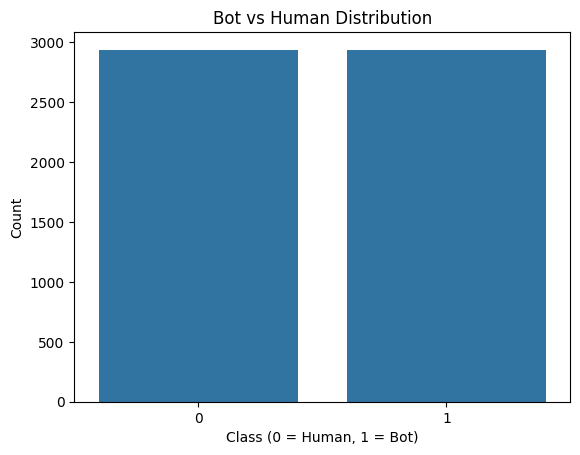

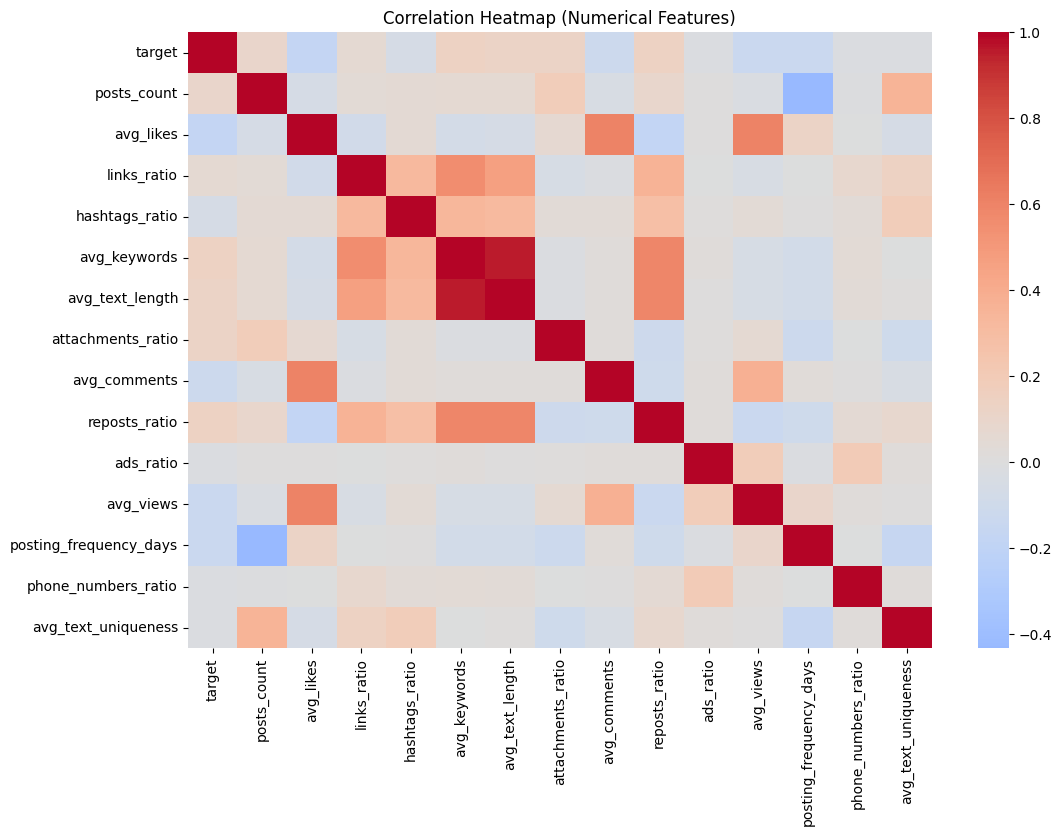

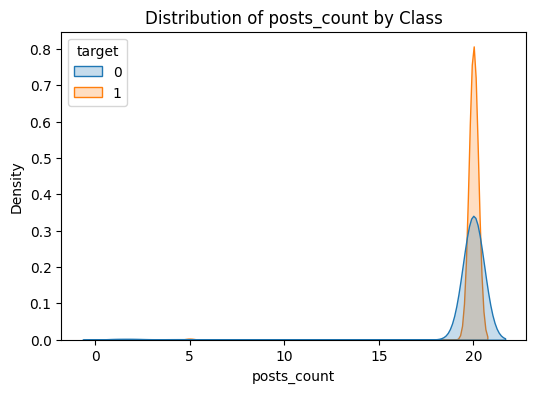

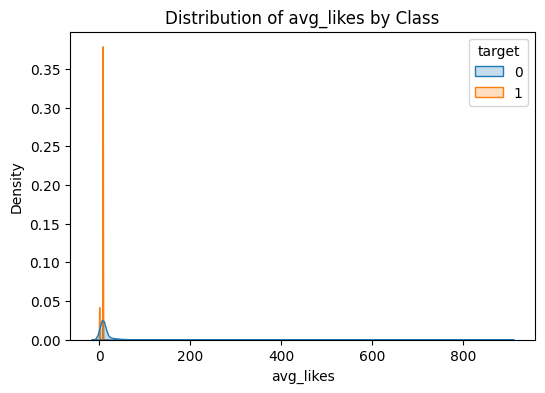

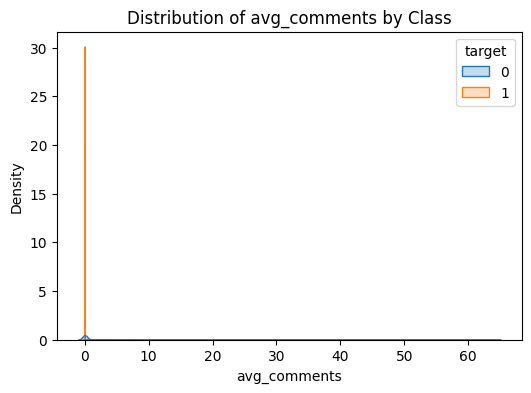

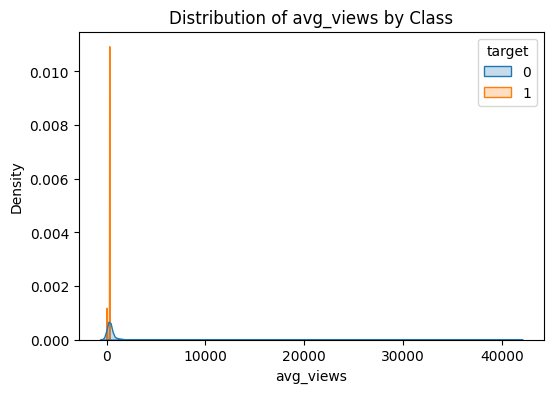

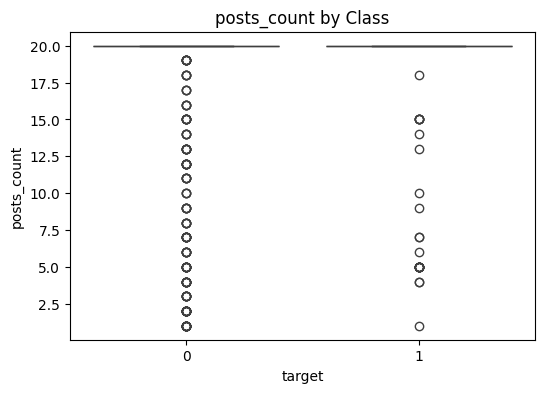

In [6]:
target_col = 'target'

# Class distribution
sns.countplot(x=target_col, data=df_clean)
plt.title("Bot vs Human Distribution")
plt.xlabel("Class (0 = Human, 1 = Bot)")
plt.ylabel("Count")
plt.show()

# Correlation heatmap of numerical features
numerical_cols = df_clean.select_dtypes(include=['float64', 'int64']).columns.tolist()

plt.figure(figsize=(12, 8))
corr = df_clean[numerical_cols].corr()
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (Numerical Features)")
plt.show()

# Example feature distribution by class
important_features = ['posts_count', 'avg_likes', 'avg_comments', 'avg_views']

for col in important_features:
    if col in df_clean.columns:
        plt.figure(figsize=(6, 4))
        sns.kdeplot(data=df_clean, x=col, hue=target_col, fill=True)
        plt.title(f"Distribution of {col} by Class")
        plt.xlabel(col)
        plt.ylabel("Density")
        plt.show()

# Boxplot for activity difference
activity_col = 'posts_count'
if activity_col in df_clean.columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=target_col, y=activity_col, data=df_clean)
    plt.title(f"{activity_col} by Class")
    plt.show()

# Feature Engineering

In [7]:
df_feat = df_clean.copy()

# Categorical and numerical columns
categorical_cols = df_feat.select_dtypes(include='object').columns.tolist()
numerical_cols = df_feat.select_dtypes(include=['float64', 'int64']).columns.tolist()
numerical_cols.remove('target')

# 1. One-hot encode categorical variables
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded = encoder.fit_transform(df_feat[categorical_cols])
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(categorical_cols), index=df_feat.index)

# Drop original categorical columns and merge encoded
df_feat.drop(columns=categorical_cols, inplace=True)
df_feat = pd.concat([df_feat, encoded_df], axis=1)

# 2. Normalize numerical features
scaler = MinMaxScaler()
df_feat[numerical_cols] = scaler.fit_transform(df_feat[numerical_cols])

# 3. Group/transform feature sets
# Combine occupation-related binary flags
if {'occupation_type_university', 'occupation_type_work'}.issubset(df_feat.columns):
    df_feat['occupation_type_other'] = 1 - (df_feat['occupation_type_university'] + df_feat['occupation_type_work'])

# 4. Add new features (interaction)
if {'avg_likes', 'avg_comments'}.issubset(df_feat.columns):
    df_feat['likes_to_comments_ratio'] = df_feat['avg_likes'] / (df_feat['avg_comments'] + 1e-5)  # avoid division by 0

print("Feature matrix shape (including target):", df_feat.shape)

Feature matrix shape (including target): (5874, 2104)


# Function

In [8]:
def prepare_df(df, target_col='target'):
    df_clean = df.copy()

    # Replace placeholder 'Unknown' if exists
    df_clean.replace('Unknown', np.nan, inplace=True)

    # Drop columns with more than 50% missing data
    df_clean = df_clean.loc[:, df_clean.isna().mean() <= 0.5]

    # Fill missing values
    categorical_cols = df_clean.select_dtypes(include='object').columns.tolist()
    numerical_cols = df_clean.select_dtypes(include=['float64', 'int64']).columns.tolist()
    if target_col in numerical_cols:
        numerical_cols.remove(target_col)

    df_clean[categorical_cols] = df_clean[categorical_cols].fillna('unknown')
    df_clean[numerical_cols] = df_clean[numerical_cols].apply(lambda x: x.fillna(x.median()))

    # Feature Engineering
    df_feat = df_clean.copy()

    # One-hot encode categorical columns
    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    encoded = encoder.fit_transform(df_feat[categorical_cols])
    encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(categorical_cols), index=df_feat.index)

    df_feat.drop(columns=categorical_cols, inplace=True)
    df_feat = pd.concat([df_feat, encoded_df], axis=1)

    # Normalize numerical features
    scaler = MinMaxScaler()
    df_feat[numerical_cols] = scaler.fit_transform(df_feat[numerical_cols])

    # Final cleanup
    df_feat.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_feat.fillna(0, inplace=True)

    # print("Feature matrix shape (including target):", df_feat.shape)
    return df_feat

# Model Evaluation

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

df = pd.read_csv("bots_vs_users.csv") 
df_clean = df.dropna(subset=['target']).copy()
X_raw = df_clean.drop(columns=['target'])
y_raw = df_clean['target'].astype(int).values
y_raw = np.where(y_raw == 0, -1, 1)

numeric_cols = X_raw.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols = X_raw.select_dtypes(include=['object']).columns.tolist()

preprocessor = ColumnTransformer(transformers=[
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', MinMaxScaler())
    ]), numeric_cols),
    
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ]), categorical_cols)
])


X_processed = preprocessor.fit_transform(X_raw)

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_processed, y_raw, test_size=0.2, random_state=42)

In [11]:
import sys
sys.path.append("/mnt/data")
from model_func import SVM

In [12]:
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def evaluate(y_true, y_pred, model_name):
    print(f"\n{model_name} Evaluation:")
    print("Accuracy :", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall   :", recall_score(y_true, y_pred))
    print("F1 Score :", f1_score(y_true, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

class LogisticRegressionFixed:
    def __init__(self, learning_rate=0.01, num_iterations=1000):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations

    def predict_probability(self, X, W, b=0):
        return 1. / (1. + np.exp(-(X @ W + b)))

    def compute_log_likelihood(self, X, Y, W, b):
        scores = X @ W + b
        logexp = np.log(1. + np.exp(-scores))
        logexp[np.isinf(logexp)] = -scores[np.isinf(logexp)]
        return np.sum((Y - 1) * scores - logexp) / len(X)

    def update_weights(self, X, Y, W, b):
        y_pred = 1 / (1 + np.exp(-(X @ W + b)))
        dW = X.T @ (Y - y_pred) / X.shape[0]
        db = np.sum(Y - y_pred) / X.shape[0]
        W += self.learning_rate * dW
        b += self.learning_rate * db
        ll = self.compute_log_likelihood(X, Y, W, b)
        return W, b, ll

    def fit(self, X, Y):
        W = np.zeros(X.shape[1])
        b = 0
        for _ in range(self.num_iterations):
            W, b, _ = self.update_weights(X, Y, W, b)
        return W, b

    def predict(self, X, W, b):
        Z = 1 / (1 + np.exp(-(X @ W + b)))
        return np.where(Z > 0.5, 1, -1)

lr_model = LogisticRegressionFixed(learning_rate=0.05, num_iterations=1000)
W_lr, b_lr = lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test, W_lr, b_lr)
evaluate(y_test, y_pred_lr, "Logistic Regression (Fixed)")

svm_model = SVM(learning_rate=0.01, lambda_param=0.1, n_iterations=1000)
W_svm, b_svm, _ = svm_model.fit(X_train, y_train, lambda_param=0.1, learning_rate=0.01, num_iterations=1000)
y_pred_svm = svm_model.predict(X_test, W_svm, b_svm)
evaluate(y_test, y_pred_svm, "SVM")




def k_fold_cv(X, y, model_class, model_name, k=5):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}

    for train_idx, val_idx in kf.split(X):
        X_train_k, X_val_k = X[train_idx], X[val_idx]
        y_train_k, y_val_k = y[train_idx], y[val_idx]

        if model_name == "Logistic Regression":
            model = model_class(learning_rate=0.05, num_iterations=1000)
            W, b = model.fit(X_train_k, y_train_k)
            y_pred = model.predict(X_val_k, W, b)
        else:
            model = model_class(learning_rate=0.01, lambda_param=0.1, n_iterations=1000)
            W, b, _ = model.fit(X_train_k, y_train_k, 0.1, 0.01, 1000)
            y_pred = model.predict(X_val_k, W, b)

        metrics['accuracy'].append(accuracy_score(y_val_k, y_pred))
        metrics['precision'].append(precision_score(y_val_k, y_pred))
        metrics['recall'].append(recall_score(y_val_k, y_pred))
        metrics['f1'].append(f1_score(y_val_k, y_pred))

    print(f"\n{model_name} 5-Fold Cross-Validation:")
    for metric, values in metrics.items():
        print(f"{metric.title()}: Mean={np.mean(values):.4f}, Std={np.std(values):.4f}")

k_fold_cv(X_processed, y_raw, LogisticRegressionFixed, "Logistic Regression")
k_fold_cv(X_processed, y_raw, SVM, "SVM")



Logistic Regression (Fixed) Evaluation:
Accuracy : 0.5336170212765957
Precision: 0.8955223880597015
Recall   : 0.09983361064891846
F1 Score : 0.17964071856287425
Confusion Matrix:
 [[567   7]
 [541  60]]

SVM Evaluation:
Accuracy : 0.9548936170212766
Precision: 0.9506578947368421
Recall   : 0.961730449251248
F1 Score : 0.9561621174524401
Confusion Matrix:
 [[544  30]
 [ 23 578]]

Logistic Regression 5-Fold Cross-Validation:
Accuracy: Mean=0.5441, Std=0.0100
Precision: Mean=0.9279, Std=0.0401
Recall: Mean=0.0960, Std=0.0093
F1: Mean=0.1737, Std=0.0149

SVM 5-Fold Cross-Validation:
Accuracy: Mean=0.9522, Std=0.0052
Precision: Mean=0.9495, Std=0.0060
Recall: Mean=0.9549, Std=0.0073
F1: Mean=0.9522, Std=0.0062


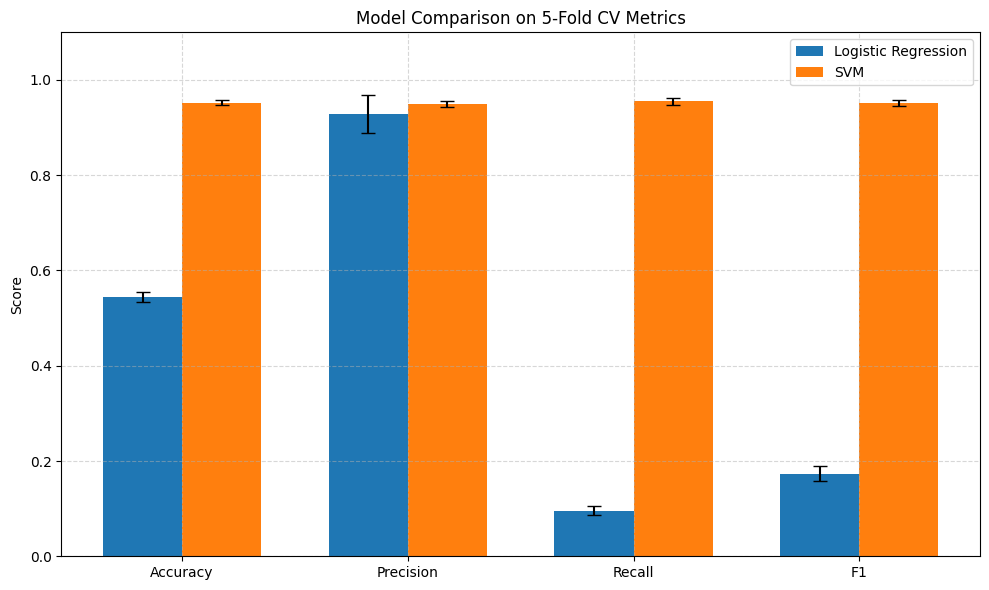

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Define metrics
models = ['LogReg', 'SVM']
metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
logreg_means = [0.5441, 0.9279, 0.0960, 0.1737]
logreg_stds  = [0.0100, 0.0401, 0.0093, 0.0149]
svm_means    = [0.9522, 0.9495, 0.9549, 0.9522]
svm_stds     = [0.0052, 0.0060, 0.0073, 0.0062]

x = np.arange(len(metrics))  # label locations
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, logreg_means, width, yerr=logreg_stds, label='Logistic Regression', capsize=5)
bars2 = ax.bar(x + width/2, svm_means, width, yerr=svm_stds, label='SVM', capsize=5)

ax.set_ylabel('Score')
ax.set_title('Model Comparison on 5-Fold CV Metrics')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 1.1)
ax.legend()
ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


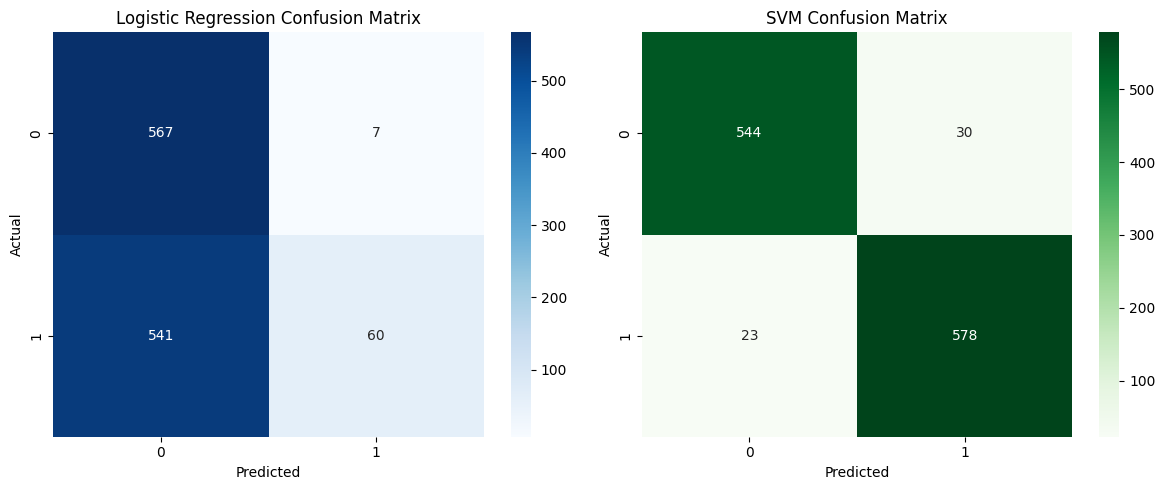

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

cm_lr = np.array([[567, 7], [541, 60]])
cm_svm = np.array([[544, 30], [23, 578]])

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title("Logistic Regression Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title("SVM Confusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()



### Get top 20 features for user input on streamlit app.

In [16]:
import re

svm_model = SVM(learning_rate=0.01, lambda_param=0.1, n_iterations=1000)
W_svm, b_svm, _ = svm_model.fit(X_train, y_train, lambda_param=0.1, learning_rate=0.01, num_iterations=1000)
y_pred_svm = svm_model.predict(X_test, W_svm, b_svm)
evaluate(y_test, y_pred_svm, "SVM")

import pandas as pd

# Assuming W_svm and preprocessor.get_feature_names_out() are already defined
importance = pd.Series(np.abs(W_svm), index=preprocessor.get_feature_names_out())
top_10 = importance.sort_values(ascending=False).head(20)

print("Top 10 Most Important Transformed Features (SVM):")
for i, (feat_name, weight) in enumerate(top_10.items(), 1):
    if feat_name.startswith("num__"):
        original_feature = feat_name.replace("num__", "")
        print(f"{i:2d}. {original_feature}  (|weight| = {weight:.4f})")
    elif feat_name.startswith("cat__"):
        # Remove prefix
        no_prefix = feat_name.replace("cat__", "")
        # Split on the LAST underscore
        if "_" in no_prefix:
            original_feature, value = no_prefix.rsplit("_", 1)
            print(f"{i:2d}. {original_feature} = {value}  (|weight| = {weight:.4f})")
        else:
            print(f"{i:2d}. {no_prefix}  (|weight| = {weight:.4f})")
    else:
        print(f"{i:2d}. {feat_name}  (|weight| = {weight:.4f})")



SVM Evaluation:
Accuracy : 0.9548936170212766
Precision: 0.9506578947368421
Recall   : 0.961730449251248
F1 Score : 0.9561621174524401
Confusion Matrix:
 [[544  30]
 [ 23 578]]
Top 10 Most Important Transformed Features (SVM):
 1. has_status = Unknown  (|weight| = 0.4981)
 2. has_status = 1.0  (|weight| = 0.3213)
 3. reposts_ratio  (|weight| = 0.2619)
 4. has_personal_data = 1.0  (|weight| = 0.2421)
 5. city = Saint Petersburg  (|weight| = 0.2280)
 6. has_status = 0.0  (|weight| = 0.2170)
 7. has_personal_data = Unknown  (|weight| = 0.2020)
 8. city = Kostomuksha  (|weight| = 0.1649)
 9. audio_available = 0.0  (|weight| = 0.1510)
10. has_website = 0.0  (|weight| = 0.1449)
11. all_posts_visible = 0.0  (|weight| = 0.1419)
12. has_website = 1.0  (|weight| = 0.1387)
13. avg_keywords  (|weight| = 0.1209)
14. has_hometown = 1.0  (|weight| = 0.1208)
15. has_hometown = 0.0  (|weight| = 0.1118)
16. is_blacklisted = 0.0  (|weight| = 0.0950)
17. is_confirmed = 0.0  (|weight| = 0.0939)
18. city =